# DNA-RNA dynamics module 2 report - Saul Pierotti
This report was made on Jupyter notebook and last revised on June 12, 2020.
The student specific parameters to be used for the report (as detailed in the assignment) are reported below.

| Parameter                |               Value |
|:-------------------------|--------------------:|
| Student number           |                  24 |
| Step 3 address           |            59625465 |
| Step 5 p-value threshold |                0.01 |
| Step 7 normalization     |   preprocessFunnorm |
| Step 9 test              |   Mann-Whitney test |

## Step 1
>Load raw data with minfi and create an object called RGset storing the RGChannelSet object.

I first clean the workspace and then import the minfi library. I do not set the working directory since I will give full paths relative to the directory in which this notebook is run.

In [1]:
rm(list=ls()) # remove all the variables from the workspace
suppressMessages(require('minfi')) # load the only required library, minfi
require(IlluminaHumanMethylation450kmanifest)
require(ggplot2)
data_dir <- './Input_data' # just for convenience to not type every time

Loading required package: IlluminaHumanMethylation450kmanifest

Loading required package: ggplot2



I load the sample sheet of the experiment to a dataframe using the minfi `read.metharray.sheet` function.

In [2]:
targets <- read.metharray.sheet(data_dir)

[read.metharray.sheet] Found the following CSV files:



[1] "./Input_data/Samplesheet_report_2020.csv"


Now I load the raw experiment data from the `Input_data` folder and I create the RGChannelSet object using the `read.metharray.exp` function. The targets are the one extracted from the sample sheet before.

In [3]:
RGset <- suppressWarnings(read.metharray.exp(base='./Input_data',targets = targets))

## Step 2
>Create the dataframes Red and Green to store the red and green fluorescences respectively.

I use the `getGreen` and `getRed` functions on the RGChannelSet object for extracting the information of the respective color channels.
These data are then converted to 2 dataframes of the same dimensionality of 8\*622399 (8 samples and 622399 addresses).

In [4]:
Red <- data.frame(getRed(RGset))
Green <- data.frame(getGreen(RGset))

## Step 3
These are the instructions:
> Fill the following table: what are the Red and Green fluorescences for the address assigned to you?
> Optional: check in the manifest file if the address corresponds to a Type I or a Type II probe and, in case of Type I probe, report its color.

The student-specific probe address assigned for this step is `59625465`.
First I note down which array and slide refers to which sample by reading the sample sheet.

In [5]:
targets

Sample_Name,Group,Age,Slide,Array,Basename
<int>,<chr>,<int>,<chr>,<chr>,<chr>
1020,DS,29,5775278051,R01C01,./Input_data/5775278051_R01C01
1036,DS,34,5775278051,R04C02,./Input_data/5775278051_R04C02
3038,WT,46,5775278078,R02C01,./Input_data/5775278078_R02C01
3042,WT,32,5775278078,R05C01,./Input_data/5775278078_R05C01
3052,WT,31,5775278078,R05C02,./Input_data/5775278078_R05C02
1016,DS,43,5930514034,R01C02,./Input_data/5930514034_R01C02
1029,DS,32,5930514035,R04C02,./Input_data/5930514035_R04C02
3029,WT,35,5930514035,R06C02,./Input_data/5930514035_R06C02


Then I extract the red and green instensity for the assigned probe by slicing the respective dataframes.

In [6]:
Red[rownames(Red)=="59625465",]
Green[rownames(Green)=="59625465",]

,X5775278051_R01C01,X5775278051_R04C02,X5775278078_R02C01,X5775278078_R05C01,X5775278078_R05C02,X5930514034_R01C02,X5930514035_R04C02,X5930514035_R06C02
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
59625465,11585,14282,11253,11494,11254,11152,11625,13019


,X5775278051_R01C01,X5775278051_R04C02,X5775278078_R02C01,X5775278078_R05C01,X5775278078_R05C02,X5930514034_R01C02,X5930514035_R04C02,X5930514035_R06C02
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
59625465,935,845,666,785,652,306,584,668


Now I load the manifest for the Illumina 450k Infinium array with the `getProbeInfo` function and check the carachetristics of the assigned probe.
I find that it is a type II probe, so there is no color to specify in the table.

In [7]:
probe_info <- getProbeInfo(RGset, type = 'II')
probe_info[probe_info$AddressA==59625465,]

DataFrame with 1 row and 4 columns
         Name    AddressA               ProbeSeqA      nCpG
  <character> <character>          <DNAStringSet> <integer>
1  cg01644972    59625465 ATATCCTAAT...TACCTCAACC         1

With all of these pieces of information I can complete the table as assigned.


| Sample | Group |      Slide | Array  | Red fluorescence | Green fluorescence | Type | Color |
|--------|-------|-----------:|--------|-----------------:|-------------------:|-----:|------:|
| 1020   | DS    | 5775278051 | R01C01 |            11585 |                935 |   II |     / |
| 1036   | DS    | 5775278051 | R04C02 |            14282 |                845 |   II |     / |
| 3038   | WT    | 5775278078 | R02C01 |            11253 |                666 |   II |     / |
| 3042   | WT    | 5775278078 | R05C01 |            11494 |                785 |   II |     / |
| 3052   | WT    | 5775278078 | R05C02 |            11254 |                652 |   II |     / |
| 1016   | DS    | 5930514034 | R01C02 |            11152 |                306 |   II |     / |
| 1029   | DS    | 5930514035 | R04C02 |            11625 |                584 |   II |     / |
| 3029   | WT    | 5930514035 | R06C02 |            13019 |                668 |   II |     / |

## Step 4
These are the instructions:
> Create the object MSet.raw

I use the `preprocessRaw` function on the RGset to get the raw Mset.

In [8]:
MSet.raw <- preprocessRaw(RGset)

## Step 5
These are the instructions:
> Perform the following quality checks and provide a brief comment to each step:
> * QCplot
> * check the intensity of negative controls using minfi
> * calculate detection pValues; for each sample, how many probes have a detection p-value higher than the threshold assigned to each student?

I first create a QC plot by getting the medians of the methylation and unmethylation channels with the `getQC` function and I plot them with the `plotQC` function.

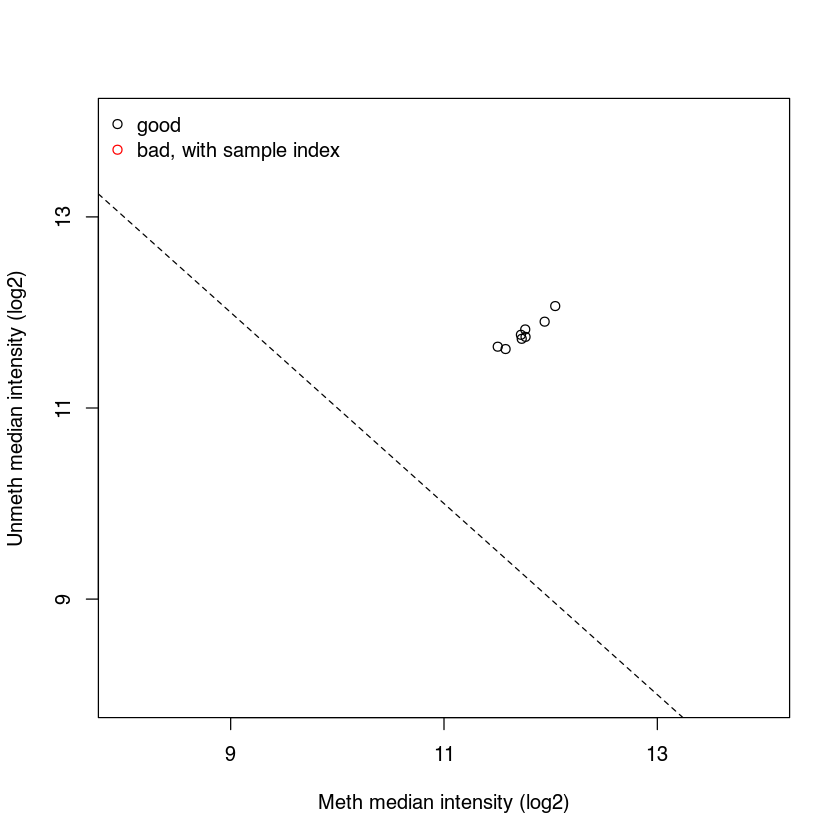

In [9]:
qc <- getQC(MSet.raw)
plotQC(qc)

Since all the samples have high median methylation and unmethylation signals, I can consider that all of them are of good quality.
Now I plot the negative control probe intensities of the RGset using the `controlStripPlot` function.

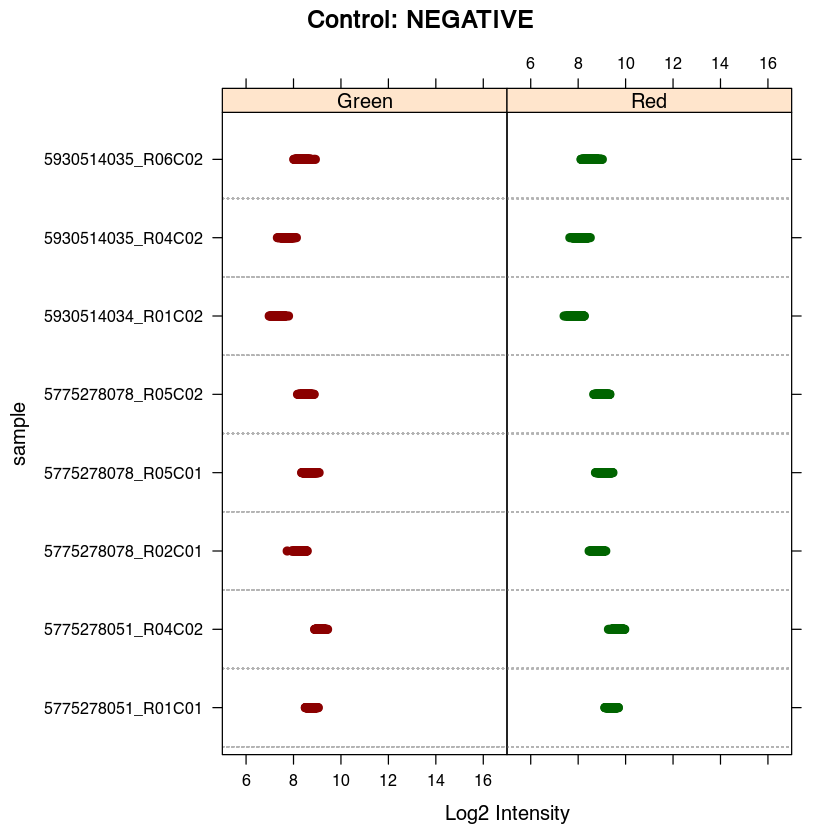

In [10]:
controlStripPlot(RGset, controls="NEGATIVE")

The represented color are inverted (the red is shown in green and vice versa). This was observed also during the lectures and it can be a bug of the package. During the lectures we also determined that the text label refers to the correct color, not the actual color of the plot.
The negative controls are all fine since their intensity is below 1000 (10 in Log2 scale).
Now I will determine the detection p-values for the probes using the `detectionP` function on the RGset.
I will consider as failed the probes with a detection p-value higher than the assigned threshold of 0.01.

In [11]:
detP <- detectionP(RGset)
failed <- detP>0.01
summary(failed)

 5775278051_R01C01 5775278051_R04C02 5775278078_R02C01 5775278078_R05C01
 Mode :logical     Mode :logical     Mode :logical     Mode :logical    
 FALSE:485189      FALSE:485252      FALSE:485200      FALSE:485027     
 TRUE :323         TRUE :260         TRUE :312         TRUE :485        
 5775278078_R05C02 5930514034_R01C02 5930514035_R04C02 5930514035_R06C02
 Mode :logical     Mode :logical     Mode :logical     Mode :logical    
 FALSE:485047      FALSE:485389      FALSE:485452      FALSE:485363     
 TRUE :465         TRUE :123         TRUE :60          TRUE :149        

The following number of probes has a p-value higher than the threshold for each one of the samples:

| Sample | Group |      Slide | Array  | Failed probes (p-value > 0.01) |
|--------|-------|-----------:|--------|-------------------------------:|
| 1020   | DS    | 5775278051 | R01C01 |                            323 |
| 1036   | DS    | 5775278051 | R04C02 |                            260 |
| 3038   | WT    | 5775278078 | R02C01 |                            312 |
| 3042   | WT    | 5775278078 | R05C01 |                            485 |
| 3052   | WT    | 5775278078 | R05C02 |                            465 |
| 1016   | DS    | 5930514034 | R01C02 |                            123 |
| 1029   | DS    | 5930514035 | R04C02 |                             60 |
| 3029   | WT    | 5930514035 | R06C02 |                            149 |

## Step 6
These are the instructions:
> Calculate raw beta and M values and plot the densities of mean
methylation values, dividing the samples in DS and WT (suggestion: subset the beta and M values matrixes in order to retain DS or WT
subjects and apply the function mean to the 2 subsets). 

I first extract the beta and M values from the MSet.raw using the `getBeta` and `getM` functions.

In [12]:
beta <- getBeta(MSet.raw)
M <- getM(MSet.raw)

Now I subset the beta and M value matrices on the basis of the group (DS or WT) of the sample.

In [13]:
isDS_bool <- targets$Group=='DS' # getting a boolean vector according to the sample group
beta_DS <- beta[,isDS_bool] # subsetting the beta values and M values on the boolean vector
beta_WT <- beta[,!isDS_bool]
M_DS <- M[,isDS_bool]
M_WT <- M[,!isDS_bool]

Now I calculate the mean beta and M values for each queried position across the 2 sample groups (across rows, MARGIN=1), discarding NA values (na.rm=T).

In [14]:
beta_DS_mean <- apply(beta_DS,MARGIN=1,mean,na.rm=T)
beta_WT_mean <- apply(beta_WT,MARGIN=1,mean,na.rm=T)
M_DS_mean <- apply(M_DS,MARGIN=1,mean,na.rm=T)
M_WT_mean <- apply(M_WT,MARGIN=1,mean,na.rm=T)

Now I can calculate the density distribution of all of these means and plot them.

In [15]:
beta_DS_mean_d <- density(beta_DS_mean)
beta_WT_mean_d <- density(beta_WT_mean)
M_DS_mean_d <- density(M_DS_mean)
M_WT_mean_d <- density(M_WT_mean)

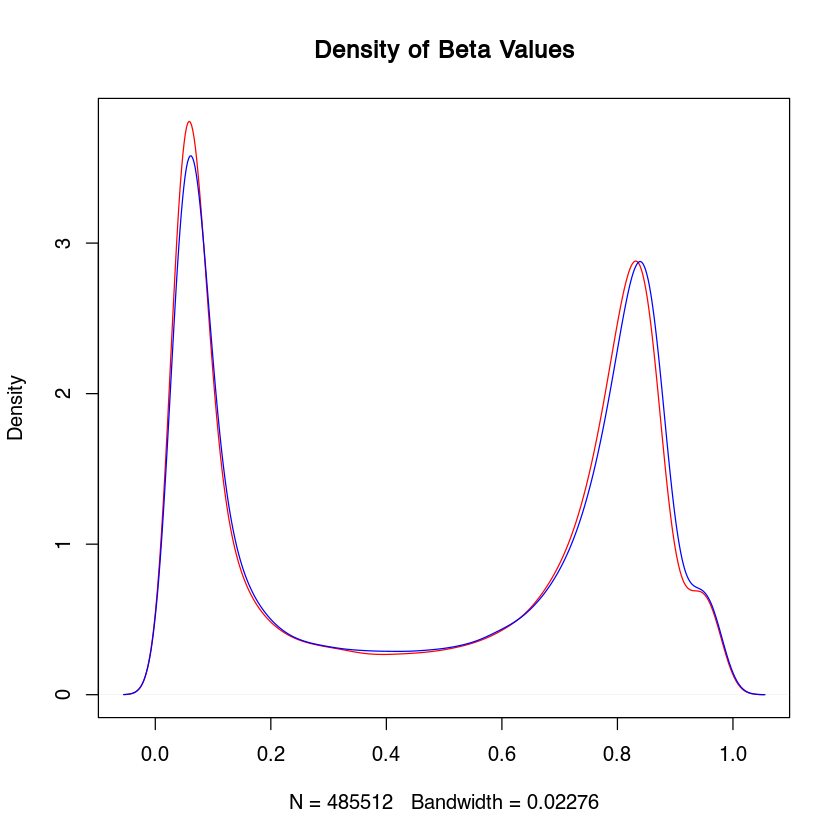

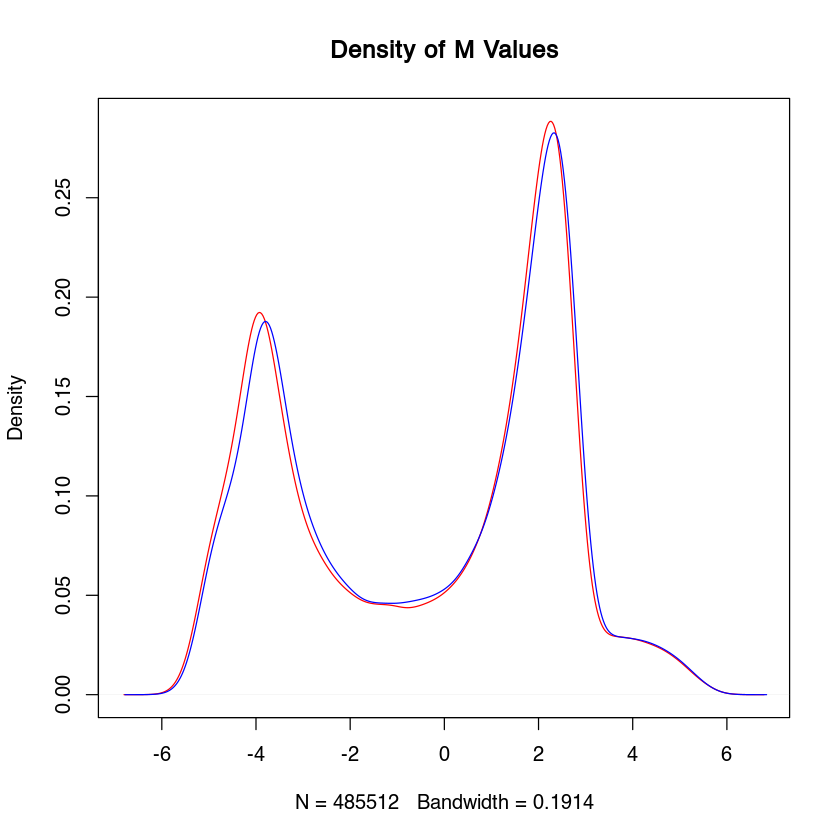

In [16]:
plot(beta_DS_mean_d,main="Density of Beta Values",col="red")
lines(beta_WT_mean_d,main="Density of Beta Values",col="blue")
plot(M_DS_mean_d,main="Density of M Values",col="red")
lines(M_WT_mean_d,main="Density of M Values",col="blue")

The red lines represents the DS samples beta/M mean density while the blue line represents that of the WT samples.
We can see how in the 2 sample groups both beta and M values tend to have a very similar distribution.

## Step 7
These are the instructions:
> Normalize the data using the function assigned to each student and
compare raw data and normalized data. Produce a plot with 6 panels
in which, for both raw and normalized data, you show the density
plots of beta mean values according to the chemistry of the probes,
the density plot of beta standard deviation values according to the
chemistry of the probes and the boxplot of beta values. Provide a
short comment regarding the changes you observe.

I first extract the type I and type II probe names from the manifest of the array and use them to subset the beta values matrix.

In [17]:
type_I <- getProbeInfo(MSet.raw, type = 'I')$Name # vector of probe IDs
type_II <- getProbeInfo(MSet.raw, type = 'II')$Name
beta_I <- beta[rownames(beta) %in% type_I,] # subset of the beta matrix containing only type I probes
beta_II <- beta[rownames(beta) %in% type_II,] # subset of the beta matrix containing only type II probes

I then calculate mean and standard deviation density for type I and type II probes.

In [18]:
mean_beta_I <- apply(beta_I,1,mean,na.rm=T)
mean_beta_II <- apply(beta_II,1,mean,na.rm=T)
d_mean_beta_I <- density(mean_beta_I)
d_mean_beta_II <- density(mean_beta_II)
sd_beta_I <- apply(beta_I,1,sd,na.rm=T)
sd_beta_II <- apply(beta_II,1,sd,na.rm=T)
d_sd_beta_I <- density(sd_beta_I)
d_sd_beta_II <- density(sd_beta_II)

I normalize (between-array) the RGset using the function assigned (`preprocessFunnorm`), which removes the variability explained by the control probes.
This will produce a GenomicRatioSet object.

In [19]:
normalized_data <- preprocessFunnorm(RGset)

[preprocessFunnorm] Background and dye bias correction with noob

Loading required package: IlluminaHumanMethylation450kanno.ilmn12.hg19

[preprocessFunnorm] Mapping to genome

[preprocessFunnorm] Quantile extraction

Warning message in .getSex(CN = CN, xIndex = xIndex, yIndex = yIndex, cutoff = cutoff):
“An inconsistency was encountered while determining sex. One possibility is that only one sex is present. We recommend further checks, for example with the plotSex function.”
[preprocessFunnorm] Normalization



I can now extract the normalized beta values using the `getBeta` function and then separate type I and type II probes as done with the original data.
I also calculate mean and standard deviation densities as before.

In [20]:
beta_norm <- getBeta(normalized_data)
beta_I_norm <- beta[rownames(beta_norm) %in% type_I,]
beta_II_norm <- beta[rownames(beta_norm) %in% type_II,]
mean_beta_I_norm <- apply(beta_I_norm,1,mean,na.rm=T)
mean_beta_II_norm <- apply(beta_II_norm,1,mean,na.rm=T)
d_mean_beta_I_norm <- density(mean_beta_I_norm)
d_mean_beta_II_norm <- density(mean_beta_II_norm)
sd_beta_I_norm <- apply(beta_I_norm,1,sd,na.rm=T)
sd_beta_II_norm <- apply(beta_II_norm,1,sd,na.rm=T)
d_sd_beta_I_norm <- density(sd_beta_I_norm)
d_sd_beta_II_norm <- density(sd_beta_II_norm)

Finally I can produce plots of mean beta value density and standard deviation density, differentiated by chemistry of the probes and for raw and normalized data.
I also produce a box plot of the beta values across samples for the raw and normalized data.

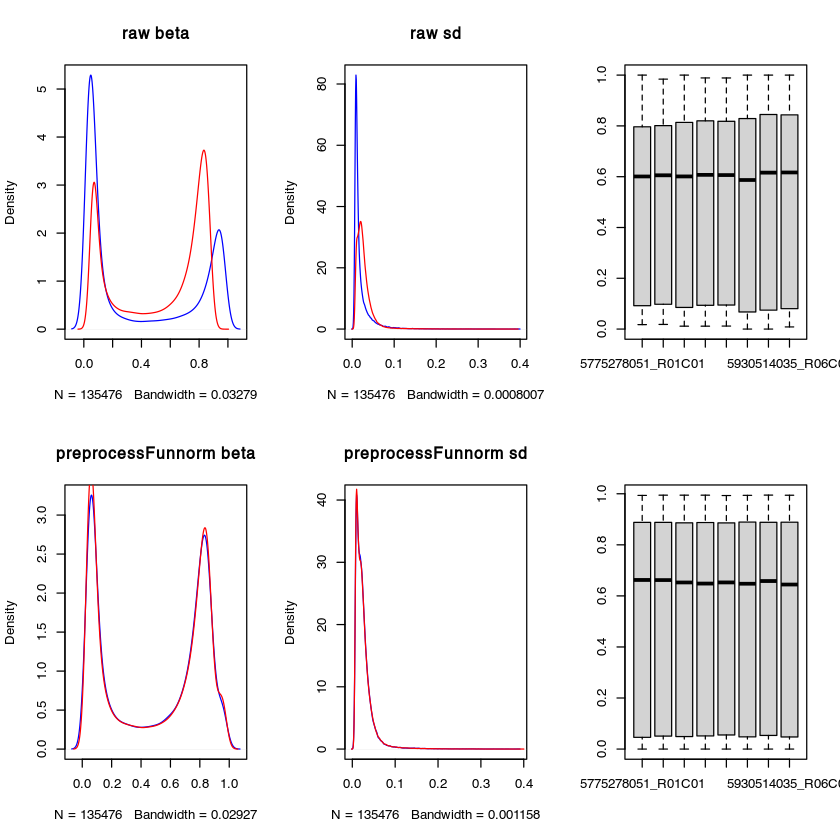

In [21]:
par(mfrow=c(2,3))
plot(d_mean_beta_I,col="blue",main="raw beta")
lines(d_mean_beta_II,col="red")
plot(d_sd_beta_I,col="blue",main="raw sd")
lines(d_sd_beta_II,col="red")
boxplot(beta)
plot(d_mean_beta_I_norm,col="blue",main="preprocessFunnorm beta")
lines(d_mean_beta_II_norm,col="red")
plot(d_sd_beta_I_norm,col="blue",main="preprocessFunnorm sd")
lines(d_sd_beta_II_norm,col="red")
boxplot(beta_norm)

I can observe that the distribution of beta values is almost identical across samples for the normalized data, while it is more variable for the raw data. Only the median in the normalized data seems to differ slightly among samples.
The distribtion of median densities and standard deviation densities is almost equivalent among type I and II probes in the normalized data, while it is heavily different in the raw data. In the raw data the density of standard deviations for type II probes tend to be shifted towards higher values compared to type I probes.
The peaks on the mean density distribution for the type II probes is more shifted towards the center compared to type I probes in the raw data.
All of these differences among chemistries in the raw data are as expected: type II probes are more variable and they show a narrower range of beta values compared to type I probes.

## Step 8
These are the instructions:
> Perform a PCA on the beta matrix generated in step 7. Comment the
plot.

I want now to apply the `prcomp` function on the normalized beta values matrix obtained in step 7 in order to perform a PCA on it.
The beta values matrix has one column per sample and one probe per row, and because of this it must be trasposed before applying the PCA (`t` function).

Importance of components:
                            PC1      PC2      PC3      PC4      PC5      PC6
Standard deviation     325.3972 295.4418 260.8247 248.7267 237.9097 231.3976
Proportion of Variance   0.2181   0.1798   0.1401   0.1274   0.1166   0.1103
Cumulative Proportion    0.2181   0.3979   0.5380   0.6654   0.7820   0.8923
                            PC7       PC8
Standard deviation     228.6972 3.059e-12
Proportion of Variance   0.1077 0.000e+00
Cumulative Proportion    1.0000 1.000e+00

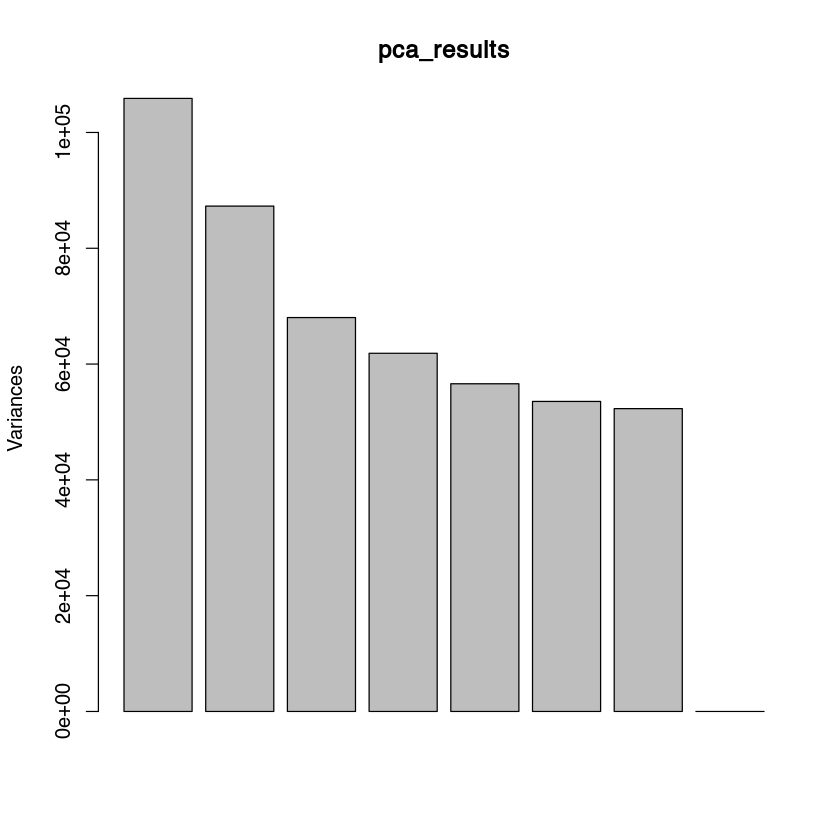

In [22]:
pca_results <- prcomp(t(beta_norm),scale=T)
summary(pca_results)
plot(pca_results)

In the screw plot, it seems that the variance is quite uniformly distributed among the first 7 components.
The 8th component contains really limited variance, and so the first 7 PC can explain almost all of the variability of the dataset.
This may mean that the samples differ sensibly on more than a few orthogonal axes.
I can plot the first 2 to principal componets to see if the DS and WT groups are separated according to those dimensions.

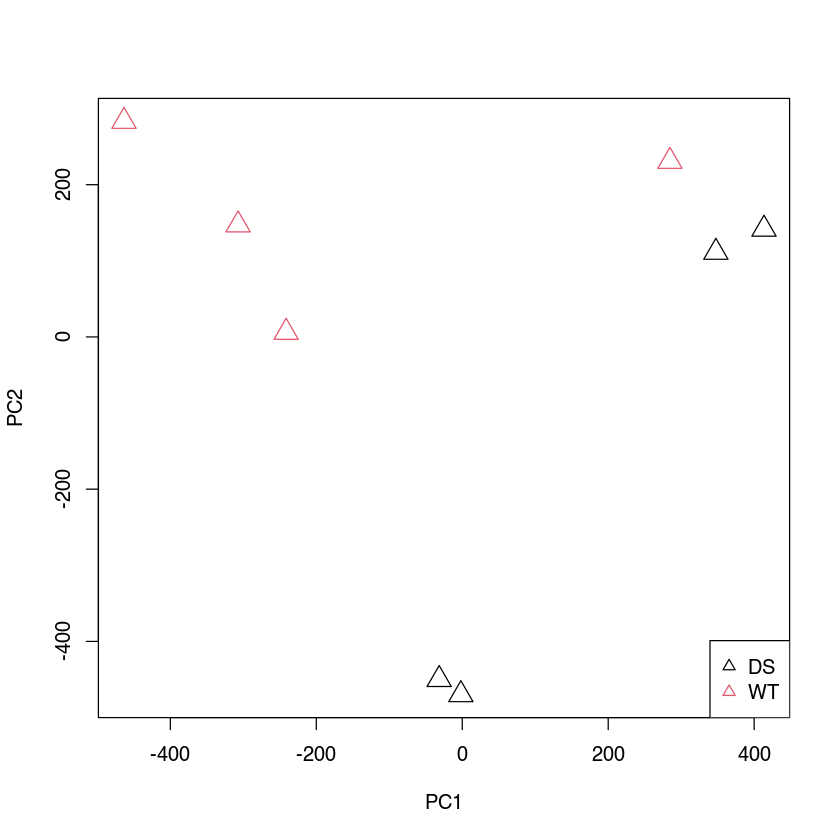

In [23]:
palette("default")
groups <- factor(targets$Group) # extract the group labels as factors
plot(pca_results$x[,1], pca_results$x[,2],cex=2,pch=2,col=groups,xlab="PC1",ylab="PC2") # make the plot and name the axes
legend("bottomright",legend=levels(groups),col=c(1:nlevels(groups)),pch=2) # add the legend

I can color the same plot according to the array used, to spot batch effects.

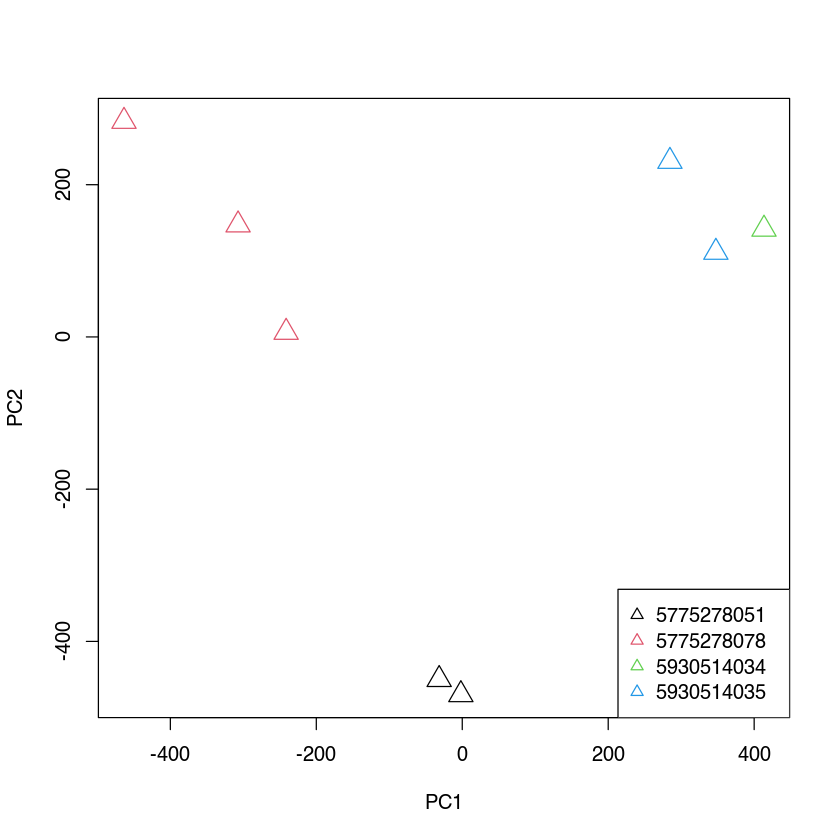

In [24]:
slides <- factor(targets$Slide)
plot(pca_results$x[,1], pca_results$x[,2],cex=2,pch=2,col=slides,xlab="PC1",ylab="PC2") # make the plot and name the axes
legend("bottomright",legend=levels(slides),col=c(1:nlevels(slides)),pch=2) # add the legend

From these plots I can see how the 2 groups (DS and WT) seem distinct according to the first 2 principal components.
A line of the type y=x seem to well separate the 2 groups.
DS seems confined to a region where PC1>PC2, while WT is confined in a region where PC2>PC1.
On the contrary, the systematic differences among slides seem to be due more to the belonging of samples run in the same slide to different groups.
Slide 5930514035, which contains a sample from the DS and a sample from the WT group, still respects the pattern of separation between sample groups.
Randomization of the samples on the slides could have been used to allow to test for batch effects separately from sample groups.

## Step 9
These are the instructions:
> Using the matrix of normalized beta values generated in step 7,
identify  differentially  methylated  probes  between  group  DS  and
group WT using the functions assigned to each student. Note; it can
take several minutes; if you encounter any problem you can run the
differential  methylated  analysis  only  on  a  subset  of  probes  (for example those on chromosome 1, 18 and 21)

The test assigned to me for the analysis of differentially methylated probes is the Mann-Whitney U test (Wilcoxon rank sum test), which is implemented in the `wilcox.test` function.
I apply it to the normalized beta values from step 7, using DS and WT as sample groups.
I need to define a function so to apply the test to each probe.

In [25]:
mann_whitney_all_rows <- function(x) {
  wilcox <- wilcox.test(x~ groups)
  return(wilcox$p.value)
}

pval_mw <- apply(beta_norm,1, mann_whitney_all_rows)

Warning message in wilcox.test.default(x = c(`5775278051_R01C01` = 0.0667157740780496, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(`5775278051_R01C01` = 0.0138523754443378, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(`5775278051_R01C01` = 0.0521902361989907, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(`5775278051_R01C01` = 0.835115001325246, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(`5775278051_R01C01` = 0.668375244205664, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(`5775278051_R01C01` = 0.0397053781863956, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(`5775278051_R01C01` = 0.967899877678577, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(`5775278051_R01C01` = 0.811508523611049, :
“cann

In [35]:
diff_met_probes <- pval_mw[pval_mw<0.05]
length(diff_met_probes)

[1] 29388

## Step 10
These are the instructpval_mw:
> Apply multiple test correction and set a significant threshold of
0.05. How many probes do you identify as differentially methylated
considering nominal pValues? How many after Bonferroni correction?
How many after BH correction?

For doing multiple test correction, I will use the `p.adjust` function, specifying which correction I want to use (BH and Bonferroni).


In [38]:
diff_met_probes_raw <- pval_mw[pval_mw<0.05]
corrected_pValues_BH <- p.adjust(pval_mw,"BH")
corrected_pValues_Bonf <- p.adjust(pval_mw,"bonferroni")
diff_met_probes_BH <- corrected_pValues_BH[corrected_pValues_BH<0.05]
diff_met_probes_Bonf <- corrected_pValues_Bonf[corrected_pValues_Bonf<0.05]
length(diff_met_probes_raw)
length(diff_met_probes_BH)
length(diff_met_probes_Bonf)

[1] 29388

[1] 0

[1] 0

A total of 29388 probes have a p-value lower than 0.05 without multiple test correction, while there are no significant probes after Bonferroni and BH correction.

## Step 11
These are the instructions:
> Produce  an  heatmap  of  the  top  100  differentially  mehtylated
probes.

## Step 12
These are the instructions:
> Produce a volcano plot and a Manhattan plot of the results of
differential methylation analysis

## Optional task
These are the instructions:
> As DS is caused by the trisomy of chromosome 21, try also to plot the
density  of  the  methylation  values  of  the  probes  mapping  on
chromosome 21. Do you see a very clear difference between the
samples? How many differentially methylated probes do you find on chromosome 21?